# 6 Численное решение ОДУ

## 6.4 Численное решение задачи Коши

Наша таблица бутчера (какая есть):

| 1/4 | 1/4    0  
| 3/4 | 1/2    1/4  
|-----|---------  
|-----| 1/2    1/2  

Начнем с проверки условий на порядки:  
0. $\forall i \: \sum_{j=1}^s a_{ij} = c_i$:     1/4 + 0 = 1/4; 1/2 + 1/4 = 3/4  
1. $\sum_{j=1}^s b_j = 1$: 1/2 + 1/2 = 1  
2. $\sum_{j=1}^s b_j c_j = 1/2: \: 1/2 \cdot  1/4 + 1/2 \cdot 3/4 = 1/8 + 3/8 = 1/2$  
3. $\sum_{j=1}^s b_j c_j^2 = 1/3:  1/2 \cdot 1/16 + 1/2 \cdot 9/16 = 1/32 + 9/32 = 10/32 \neq 1/3$  

Выполняются все условия до третьего, а третье -- не выполняется. Значит, метод четвертого порядка.

Перейдем к реализации метода.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [187]:
def solve_Newton(x0, f, Jf, tol=1e-15):
    # начальное будем передавать, чтобы 
    # не думать о размерностях
    x = np.array(x0)
    xp = x0 + 1
    for _ in range(10):
        if np.max(np.abs(x - xp)) < tol:
            break
        xp = x
        # singular matrices???
        diff_x = np.linalg.solve(Jf(xp), -f(xp))
        # diff_x = -f(xp) / Jf(xp)
        x = xp + diff_x
    return x

def solve_rk(T, u0, f, Jf, N, tol=1e-15, a=[[1/4, 0], [1/2, 1/4]], 
                c=[1/4, 3/4], b=[1/2, 1/2]):
    u = np.empty((N + 1, len(u0)))
    t = np.linspace(0, T, N + 1)
    h = T / (N + 1)
    u[0] = u0
    for n in range(N):
        # подойдет любая верхнетреугольная матрица a размера 2 
        k0 = solve_Newton(np.zeros(u0.shape), lambda x : f(t[n] + c[0] * h, u[n] + a[0][0] * h * x) - x,
            lambda x : Jf(t[n] + c[0] * h, x) * h * a[0][0] - np.eye(len(u0)), tol=tol)
        k1 = solve_Newton(np.zeros(u0.shape), lambda x : f(t[n] + c[1] * h, u[n] + h * (a[1][0] * k0 + a[1][1] * x)) - x,
            lambda x : Jf(t[n] + c[1] * h, x) * h * a[1][1] - np.eye(len(u0)), tol=tol)
        u[n + 1] = u[n] + h * (b[0] * k0 + b[1] * k1)
    return u

Подготовим функцию, которая будет строить нам графики.

In [188]:
def solve_and_plot(T, u0, f, Jf, N, y_exact):
    u = solve_rk(T, u0, f, Jf, N)
    x_arr = np.linspace(0, T, N + 1)
    fig = plt.figure(figsize=(20, 6))
    gs = gridspec.GridSpec(1, 2)
    plt.subplot(gs[0, 0])
    plt.scatter(x_arr, u[:,0], label="Approximation", color="crimson")
    plt.plot(x_arr, [y_exact(x) for x in x_arr], label="Exact", color="black")
    plt.xlabel("$x$", size=14)
    plt.ylabel("$y(x)$", size=14)
    plt.legend()
    plt.subplot(gs[0, 1])
    plt.plot(x_arr, u[:,0] - np.array([y_exact(x) for x in x_arr]))
    plt.xlabel("$x$", size=14)
    plt.ylabel("$|y(x) - \hat{y}(x)|$", size=14)

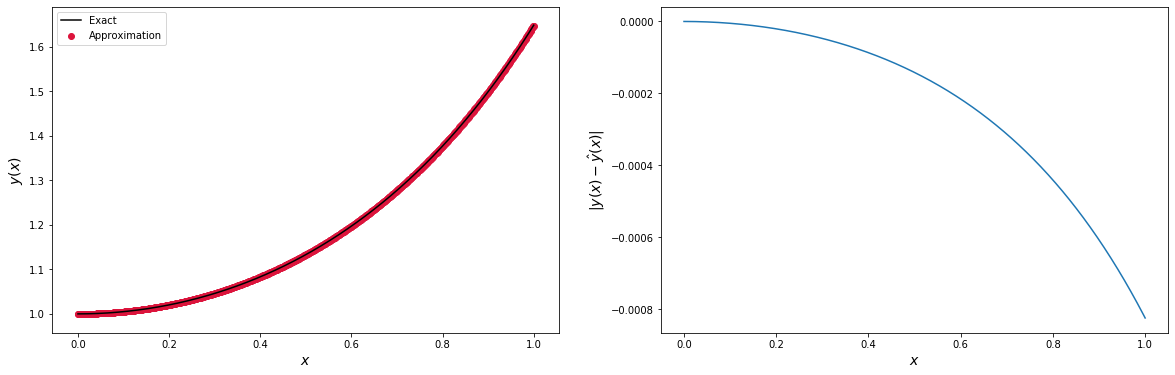

In [193]:
solve_and_plot(f = lambda x, y : x * y,
    Jf = lambda x, y : np.array([[x]]),
    y_exact = lambda x : np.exp(x ** 2 / 2),
    T = 1,
    N = 1000,
    u0 = np.array([1]))

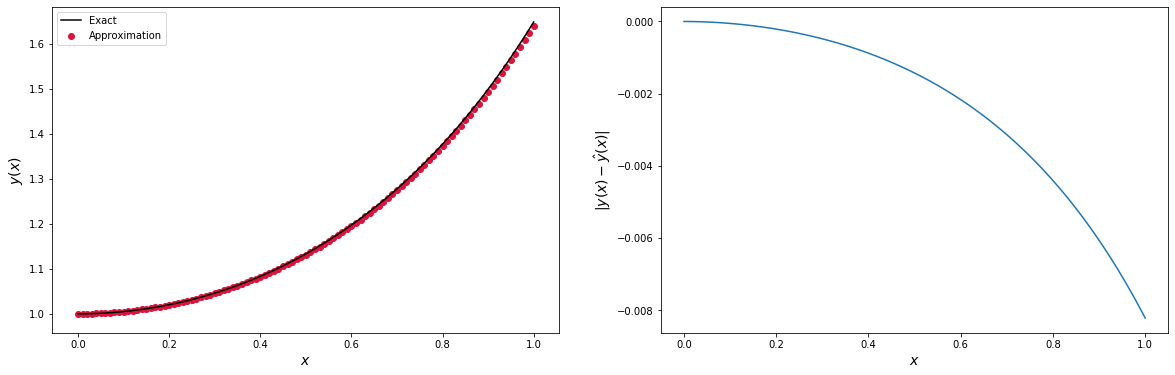

In [194]:
solve_and_plot(f = lambda x, y : x * y,
    Jf = lambda x, y : np.array([[x, 0], [0, x]]),
    y_exact = lambda x : np.exp(x ** 2 / 2),
    T = 1,
    N = 100,
    u0 = np.array([1, 1]))

Теперь перейдем к функции, которая будет строить нам график точности в зависимости от размера сетки.

In [195]:
def plot_error(T, u0, f, Jf, y_exact, d=15):
    err = np.empty(d)
    err_th = np.empty(d)
    h_arr = np.empty(d)
    N_arr = 2 ** np.arange(2, d + 2)
    for i, N in enumerate(N_arr):
        approximate = solve_rk(T, u0, f, Jf, N, tol=1e-20)
        x_arr = np.linspace(0, T, N + 1)
        h = (T / (N + 1))
        exact = np.array([y_exact(x) for x in x_arr])
        err[i] = h * np.sum(np.abs(exact - approximate[:,0]))
        err_th[i] = h
        h_arr[i] = h
    plt.loglog(h_arr, err, label="Real", color="crimson")
    plt.loglog(h_arr, err_th * (err[0] / err_th[0]), label="Theoretical", color="black")
    plt.xlabel('Число узлов')
    plt.ylabel('Ошибка')
    plt.legend()

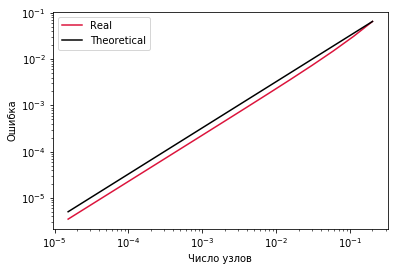

In [196]:
plot_error(f = lambda x, y : x * y,
    Jf = lambda x, y : np.array([[x]]),
    y_exact = lambda x : np.exp(x ** 2 / 2),
    T = 1,
    u0 = np.array([1]))